# SQLAlchemy Homework - Surfs Up!

## Import Dependencies

In [1]:
%matplotlib inline

In [2]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os

import datetime as dt

In [3]:
# Files Locations:
database_file = os.path.join('Resources','hawaii.sqlite')
precipitation_plot = os.path.join('Images','precipitation.png')
station_plot = os.path.join('Images','station-histogram.png')
avg_temp = os.path.join('Images','Trip_Avg_Temp.png')
normals_plot =os.path.join('Images','daily_normals.png')

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Use SQLAlchemy create_engine to connect to your sqlite database.
engine = create_engine(f"sqlite:///{database_file}")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# View the columns associated with the table
Measurement.__table__.columns.values()

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [10]:
# If you just want a list of the column headers, run:
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [11]:
# If you just want a list of the column headers, run:
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

In [13]:
# Retrieve the most recent meas data
date_last_meas_str = session.query(func.max(Measurement.date))

# Convert the data from string to datetime
date_last_meas_object = dt.datetime.strptime(date_last_meas_str.first()[0], '%Y-%m-%d').date()

# Create a query data interval
query_date = date_last_meas_object - dt.timedelta(days=365)

# Query the database based on the target date (last 365 days)
precipitation_query= session.query(Measurement.date,
                                   Measurement.prcp).filter(Measurement.date > query_date).all()

In [14]:
# Load the query results into a Pandas DataFrame and set the index to the date column.
precipitation_12_months = pd.DataFrame(precipitation_query).set_index('date', drop=True)

# Sort the DataFrame values by date
precipitation_12_months.sort_values('date',inplace=True)

In [15]:
# Drop the NAN values
precipitation_12_months_cleaned = precipitation_12_months.loc[precipitation_12_months['prcp'].isnull()==False]

<Figure size 432x288 with 0 Axes>

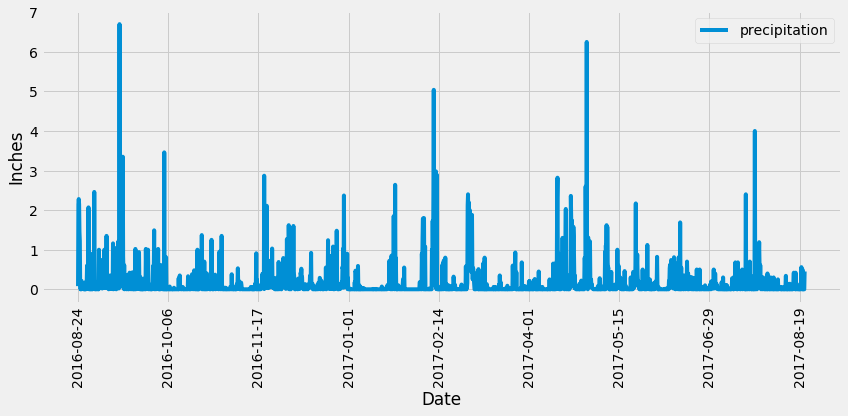

In [16]:
# Plot the results using the DataFrame plot method
plt.figure()
ax = precipitation_12_months_cleaned.plot(figsize=(12,6),rot=90)
ax.set_ylabel('Inches')
ax.set_xlabel('Date')
ax.legend(["precipitation"]);
plt.tight_layout()
plt.savefig(precipitation_plot)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_12_months_cleaned.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [18]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Station.id).count()
print(f"There are {available_stations} stations are available in this dataset.")

There are 9 stations are available in this dataset.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Station.station,func.count(Station.station)).filter(
                                        Measurement.station == Station.station).group_by(
                                        Station.station).order_by(
                                        func.count(Station.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station_id  = most_active_stations[0][0]

# lowest temperature recorded
lowest_temperature = session.query(Measurement.tobs).filter(
                                Measurement.station == most_active_station_id).order_by(
                                Measurement.tobs.asc()).first()
print(f"The lowest temperature recorded at station {most_active_station_id} is {lowest_temperature[0]} F.")

# highest temperature recorded
highest_temperature = session.query(Measurement.tobs).filter(
                                Measurement.station == most_active_station_id).order_by(
                                Measurement.tobs.desc()).first()
print(f"The highest temperature recorded at station {most_active_station_id} is {highest_temperature[0]} F.")

# average temperature
average_temperature = session.query(func.avg(Measurement.tobs)).filter(
                                Measurement.station == most_active_station_id).first()
print(f"The average temperature recorded at station {most_active_station_id} is {round(average_temperature[0],2)} F.")

The lowest temperature recorded at station USC00519281 is 54.0 F.
The highest temperature recorded at station USC00519281 is 85.0 F.
The average temperature recorded at station USC00519281 is 71.66 F.


In [21]:
# Query the last 12 months of temperature observation data for this station 
tobs_12_months = session.query(Measurement.date, Measurement.tobs).filter(
                                    Measurement.date > query_date).filter(
                                    Measurement.station == most_active_station_id).statement

# Use Pandas read_sql_query to load a query statement directly into the DataFrame
temperature_observation = pd.read_sql_query(tobs_12_months, session.bind).set_index('date', drop=True)

# Drop the NAN values
temperature_observation_clean = temperature_observation.loc[temperature_observation['tobs'].isnull()==False]

temperature_observation_clean.describe()

,tobs
count,351.000000
mean,73.096866
std,4.735491
min,59.000000
25%,70.000000
50%,74.000000
75%,77.000000
max,83.000000


<Figure size 432x288 with 0 Axes>

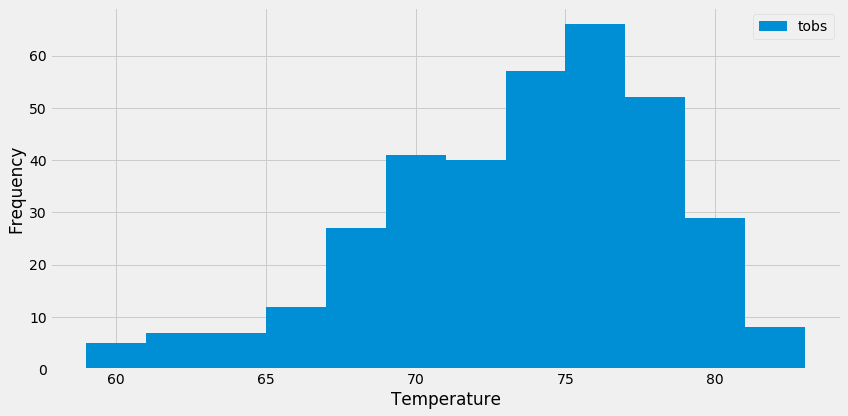

In [22]:
# Plot the results as a histogram
plt.figure()
ax = temperature_observation_clean.plot.hist(figsize=(12,6),bins=12)
ax.set_xlabel('Temperature')
plt.tight_layout()
plt.savefig(station_plot)

## Additional Analyses

### Temperature Analysis I

In [23]:
# Vacation Dates
start_date = '2012-03-01'
end_date =  '2012-03-14'

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps(start_date, end_date))

[(61.0, 68.76470588235294, 75.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_calc = calc_temps(start_date, end_date)
print(temp_calc)

[(61.0, 68.76470588235294, 75.0)]


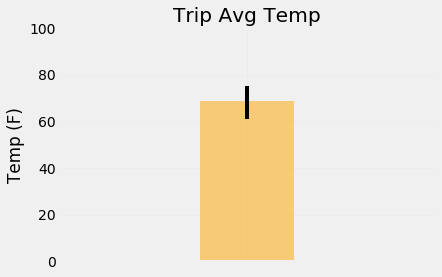

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x =[1] 
y =[temp_calc[0][1]] 

# creating error 
y_errormin =[temp_calc[0][1]-temp_calc[0][0]] 
y_errormax =[temp_calc[0][2]-temp_calc[0][1]] 
x_error = 0
y_error =[y_errormin, y_errormax] 


# ploting graph 
plt.bar(x, y, color='orange', alpha=.5, width=0.5) 
plt.errorbar(x, y, yerr = y_error, xerr = x_error, fmt ='k')
plt.xticks(x, (''))
plt.ylim([0, 100])
plt.xlim([0, 2])
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.grid('--',alpha=.1)
plt.savefig(avg_temp)

### Temperature Analysis II

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date
end_date
# Use the start and end date to create a range of dates
vacation_dates = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Stip off the year and save a list of %m-%d strings
list_days= vacation_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for day in list_days:
  normals.append(daily_normals(day)[0])

dailynormals = pd.DataFrame(normals, columns =['tmin', 'tavg','tmax'])

In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dailynormals['Date']=vacation_dates
dailynormals.set_index('Date', inplace=True)
dailynormals

,tmin,tavg,tmax
Date,,,
2012-03-01,64.0,70.032787,76.0
2012-03-02,61.0,70.366667,78.0
2012-03-03,60.0,70.068966,78.0
2012-03-04,57.0,69.272727,77.0
2012-03-05,60.0,67.890909,76.0
2012-03-06,60.0,69.203390,76.0
2012-03-07,60.0,69.172414,78.0
2012-03-08,59.0,68.724138,78.0
2012-03-09,57.0,68.561404,75.0


<Figure size 432x288 with 0 Axes>

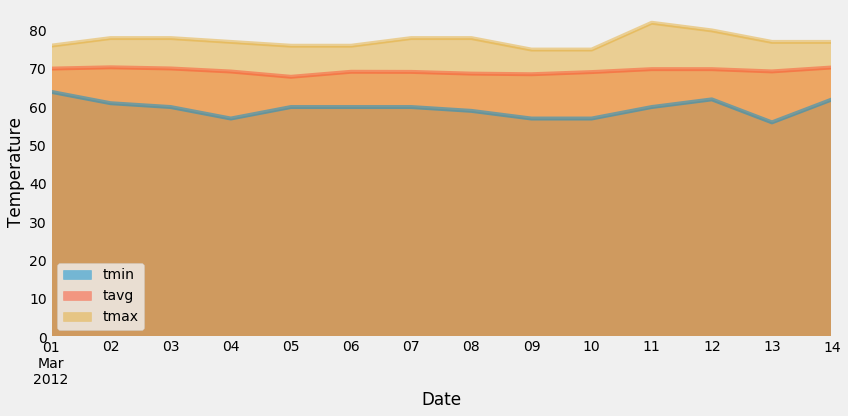

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
plt.figure()
ax = dailynormals.plot.area(figsize=(12,6),stacked=False)
ax.set_ylabel('Temperature')
ax.set_xlabel('Date')
plt.tight_layout()
plt.grid()
plt.savefig(normals_plot)